## Initialization

In [88]:
# Imports: 
import random
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats.sampling import DiscreteAliasUrn
from scipy.stats import chi
from scipy.stats import geom, kstest
import time


## 1) Geometric distribution
- Choose a value for p and sample 10.000 samples from geometric distribution.

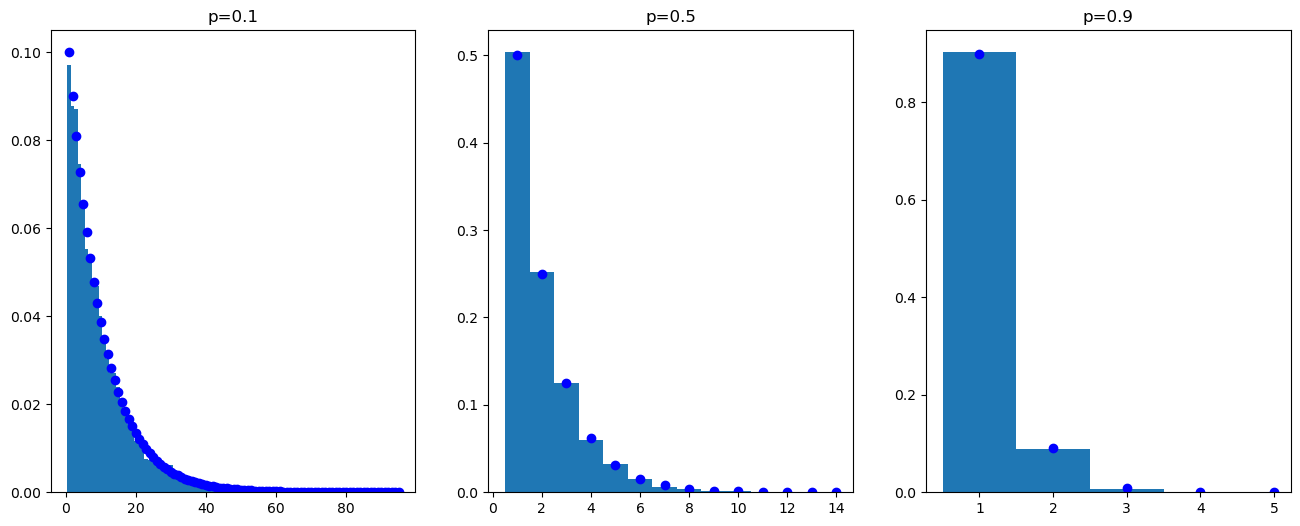

In [56]:
# chosen value for p is
p = [0.1, 0.5, 0.9]
N = 10000
def GeoRandVar(p,N):
    return np.random.geometric(p, N)

figure, axis = plt.subplots(1, 3,figsize=(16, 6)) 

for i in range(len(p)):
    #Sample 
    Geo_samples = GeoRandVar(p[i],N)

    # plot sample 
    axis[i].hist(Geo_samples, bins=np.arange(1, max(Geo_samples) + 1) - 0.5,density=True)
    axis[i].set_title(f'p={p[i]}')

    #plot theoretical
    x = np.arange(1, max(Geo_samples) + 1)
    pmf = geom.pmf(x, p[i])
    axis[i].plot(x, pmf, 'bo')

plt.show() 


## 6-point Distribution: 
- Simulate the 6-point distribution using the crude, rejection and alias Method

In [81]:
# Define the discrete distribution
X = np.array([1, 2, 3, 4, 5, 6])
P = np.array([7/48, 5/48, 1/8, 1/16, 1/4, 5/16])
N = 10000

## Direct (Crude) Method

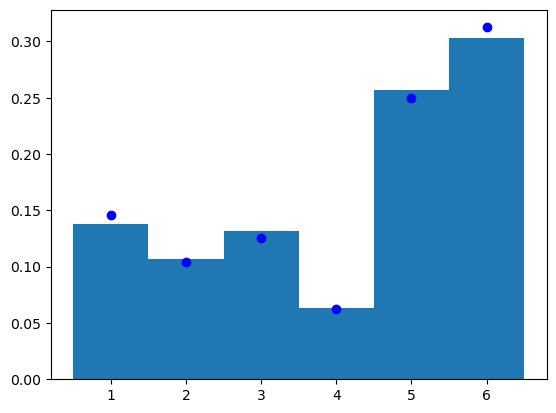

In [82]:

def DirectMethod(X,P,N):
    Sample_Crude = []
    U = np.random.uniform(0, 1, N)

    for i in range(N):
        x = 0
        if U[i] < np.sum(P[0:1]):
            x = X[0]
        elif U[i] < np.sum(P[0:2]):
            x = X[1]
        elif U[i] < np.sum(P[0:3]):
            x = X[2]
        elif U[i] < np.sum(P[0:4]):
            x = X[3]
        elif U[i] < np.sum(P[0:5]):
            x = X[4]
        else:
            x = X[5]
        Sample_Crude.append(x)
    return Sample_Crude

        
plt.hist(DirectMethod(X,P,N), bins=np.arange(1, 8) - 0.5, density=True)
plt.plot(X,P,'bo')
plt.xticks(X)
plt.show()
# looks good from histogram

## 6-point distribution: Rejection Method 

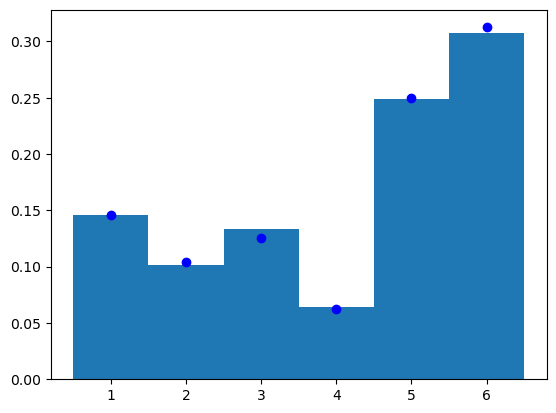

In [83]:

def RejectionMethod(X,P,N):
    n = len(P)
    q = 1/n*np.ones(n)

    c = np.max(P/q)

    Sample_Rej = []
    for i in range(N):
        x = 0
        bo = True 
        while bo:
            U1 = random.uniform(0, 1)
            U2 = random.uniform(0, 1)
            Y = int(n*U1)+1
            
            if U2 < P[Y-1] / c*q[Y-1]:
                x = Y
                bo = False
        Sample_Rej.append(x)
    return Sample_Rej

plt.hist(RejectionMethod(X,P,N), bins=np.arange(1, 8) - 0.5, density=True)
plt.plot(X,P,'bo')
plt.xticks(X)
plt.show()

## 6-point distribution: Alias Method 

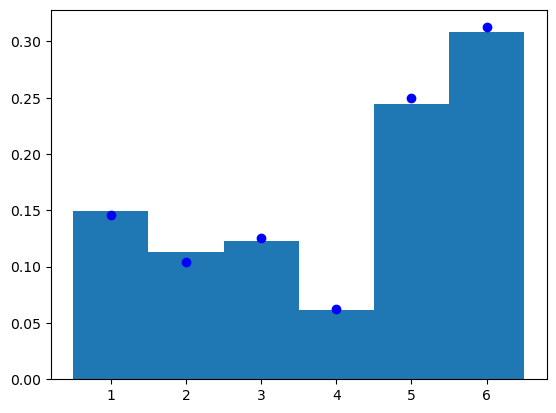

In [87]:

def AliasMethod(X,P,N):
    rng = DiscreteAliasUrn(P)
    Samples_ali = rng.rvs(N)

    return Samples_ali+1


plt.hist(AliasMethod(X,P,N), bins=np.arange(1, 8)-0.5, density=True)
plt.plot(X,P,'bo')
plt.show()

## Comparing Methods
- Compare the three different methods using adequate criteria and discuss results

In [89]:

def ChiSquare_test(samples, expected_prob):

    observed_counts = np.bincount(samples)[1:]
    expected_counts = expected_prob * N
    chi2_stat = np.sum((observed_counts - expected_counts)**2 / expected_counts)

    return chi2_stat

start_time = time.time()
direct_sample = DirectMethod(X,P,N)
direct_time = time.time() - start_time
direct_Chi = ChiSquare_test(direct_sample, P)

start_time = time.time()
Rejec_sample = RejectionMethod(X,P,N)
Rejec_time = time.time() - start_time
Rejec_Chi = ChiSquare_test(Rejec_sample, P)

start_time = time.time()
Ali_sample = AliasMethod(X,P,N)
Ali_time = time.time() - start_time
Ali_Chi = ChiSquare_test(Ali_sample, P)


print(f"Method\t\tTime (s)\tChi-Square Statistic")
print(f"Direct\t\t{direct_time:.4f}\t\t{direct_Chi:.4f}")
print(f"Rejection\t{Rejec_time:.4f}\t\t{Rejec_Chi:.4f}")
print(f"Alias\t\t{Ali_time:.4f}\t\t{Ali_Chi:.4f}")


Method		Time (s)	Chi-Square Statistic
Direct		0.1328		2.7227
Rejection	0.5014		8.0312
Alias		0.0006		0.6200
